# Analysis of URs that are TSM using Jaspar DB

## Functions 


In [1]:
import os
import numpy as np
from pprint import pprint
import openpyxl as opxl
import matplotlib
import matplotlib.pyplot as plt
import translation as tran  # my translation functions
import re
import random
import pandas as pd

def parse_jaspar_TF(fname):
    '''Parses the .jaspar Individual PFMs file. See
    http://jaspar.genereg.net/downloads/.  
    File example:
    >MA0002.2	RUNX1
    A  [   287    234    123     57      0     87      0     17     10    131    500 ]
    C  [   496    485   1072      0     75    127      0     42    400    463    158 ]
    G  [   696    467    149      7   1872     70   1987   1848    251     81    289 ]
    T  [   521    814    656   1936     53   1716     13     93   1339   1325   1053 ]
    '''
    with open(fname, 'rt') as file:
        # read TF name
        fline = file.readline()
        TFname = fline.split()[1]
        
        # read PFM
        larray = np.array([line.split() for line in file]) # lines 2 to 5 have the same number of elements
        nucl = larray[0:,0] # first column (column 0) is the nucleotide letter
        pwm = larray[0:,2:-1] # second column to column before end are the PWM of the corresponding nucleotide
        cons_seq = ''.join([nucl[i] for i in np.argmax(pwm.astype(np.int), axis=0) ]) # consensus sequence
    return TFname, cons_seq, pwm, nucl

def get_all_Jaspar_TF_info(j_dname, ext_name='jaspar'):
    '''Reads all Jaspar files in the input directory and
    returns the TF_info dictionary, where key is the seq, and value is the TF name'''
    TF_info = {} # get all TF info as key: seq, value: TF name
    for fname in [f for f in os.listdir(j_dname) if f.endswith(ext_name)]:
        tfn, cons_seq, _, _ = parse_jaspar_TF(os.path.join(j_dname, fname))
        TF_info[cons_seq] = tfn
    return TF_info

def get_virus_URs_of_host(UR_xlsx_file, UR_tax_group):
    '''Gathers all top URs of viruses corresponding to a particular
    host domain and returns the UR_taxg_info dictionary, 
    where key is the host name, and value is the top UR'''
    sheet = opxl.load_workbook(UR_xlsx_file).active
    # get all top URs of viruses corresponding to tax_group
    UR_taxg_info = {}
    for i in [i for i in range(2,sheet.max_row+1) if sheet.cell(row=i,column=1).value == UR_tax_group]:
        UR_taxg_info[sheet.cell(row=i,column=2).value] = sheet.cell(row=i,column=4).value
    return UR_taxg_info

def process_jaspar_UR(j_dname, UR_xlsx_file, UR_tax_group, dbg = False):
    '''This function evaluates the number of TF recognition sites
    that contain one of the top viruses UR (corresponding to a
    specific host domain) as subset sequence. The evaluation
    is per host tax group (domain).'''
    # gather all Jaspar TF information in the folder j_dname
    TF_info = get_all_Jaspar_TF_info(j_dname)
    if dbg: print('Total of {} TF sequences gathered'.format(len(TF_info)))

    # get all top URs of viruses corresponding to tax_group
    UR_info = get_virus_URs_of_host(UR_xlsx_file, UR_tax_group)
    # the set of all top URs in viruses corresponding to UR_tax_group
    UR_set = [s for s in set(UR_info.values()) if s != None]
    if dbg: print('Total of {} top URs sequences gathered'.format(len(UR_set)))

    # check if a UR is a subsequence of a TF recognition sequence
    rseq = list(TF_info.keys())
    recog_info = {} # key: UR seq, value: [pairs of TF seq : TF name]
    for s in UR_set:
        # for each key s, value is a list of pairs of TF seq : TF name, where s is in TF seq
        recog_info[s] = [TF_info[i] if y else i for i in rseq for y in range(2) if s in i]
    num_recog = [(len(recog_info[s])/2)/len(rseq)*100 for s in UR_set] # percentage of TFs that UR is a subset of
    return num_recog, UR_set, TF_info, UR_info, recog_info

def calc_pvalue_jaspar(wt_num, TF_info, rand_seq_len, num_rands=1000):
    '''This function returns the p-value of each wt_num[i] based on the dictionary TF_info.
    The p-value is calculated here based on randomly generating a sequence as a UR'''
    l = len(wt_num)
    wt = np.array(wt_num)
    pval = np.zeros(l)
    for i in range(num_rands):
        rseq = tran.gen_random_bp_seq(rand_seq_len, True) # random sequence
        rand = len([k for k in TF_info.keys() if rseq in k])*np.ones(l)
        pval += (rand>=wt).astype(int)
    return pval/num_rands

def calc_pvalue_randin_jaspar(wt_num, TF_info, rand_seqs, num_rands=1000):
    '''This function uses the input rand_seqs list of random sequences and randomly
    selects sequences from it to compute the p-value'''
    l = len(wt_num)
    rl = len(rand_seqs)
    wt = np.array(wt_num)
    pval = np.zeros(l)
    for i in range(num_rands):
        rseq = rand_seqs[random.randint(0,rl-1)]
        rand = len([k for k in TF_info.keys() if rseq in k])*np.ones(l)
        pval += (rand>=wt).astype(int)
    return pval/num_rands

## Main Code

The code below uses a list of URs computed for RANDOM viruses for evaluating p-values. In the xlsx file that contains these URs (see base_rnd_path), each UR appears multiple times, based on how many times it appaered as a UR in the (random) viruses. Thus, selecting randomly from this list provides a distribution that is determined by the multiplicity of each UR.

Figure saved in URs_Jasper.png (in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter)


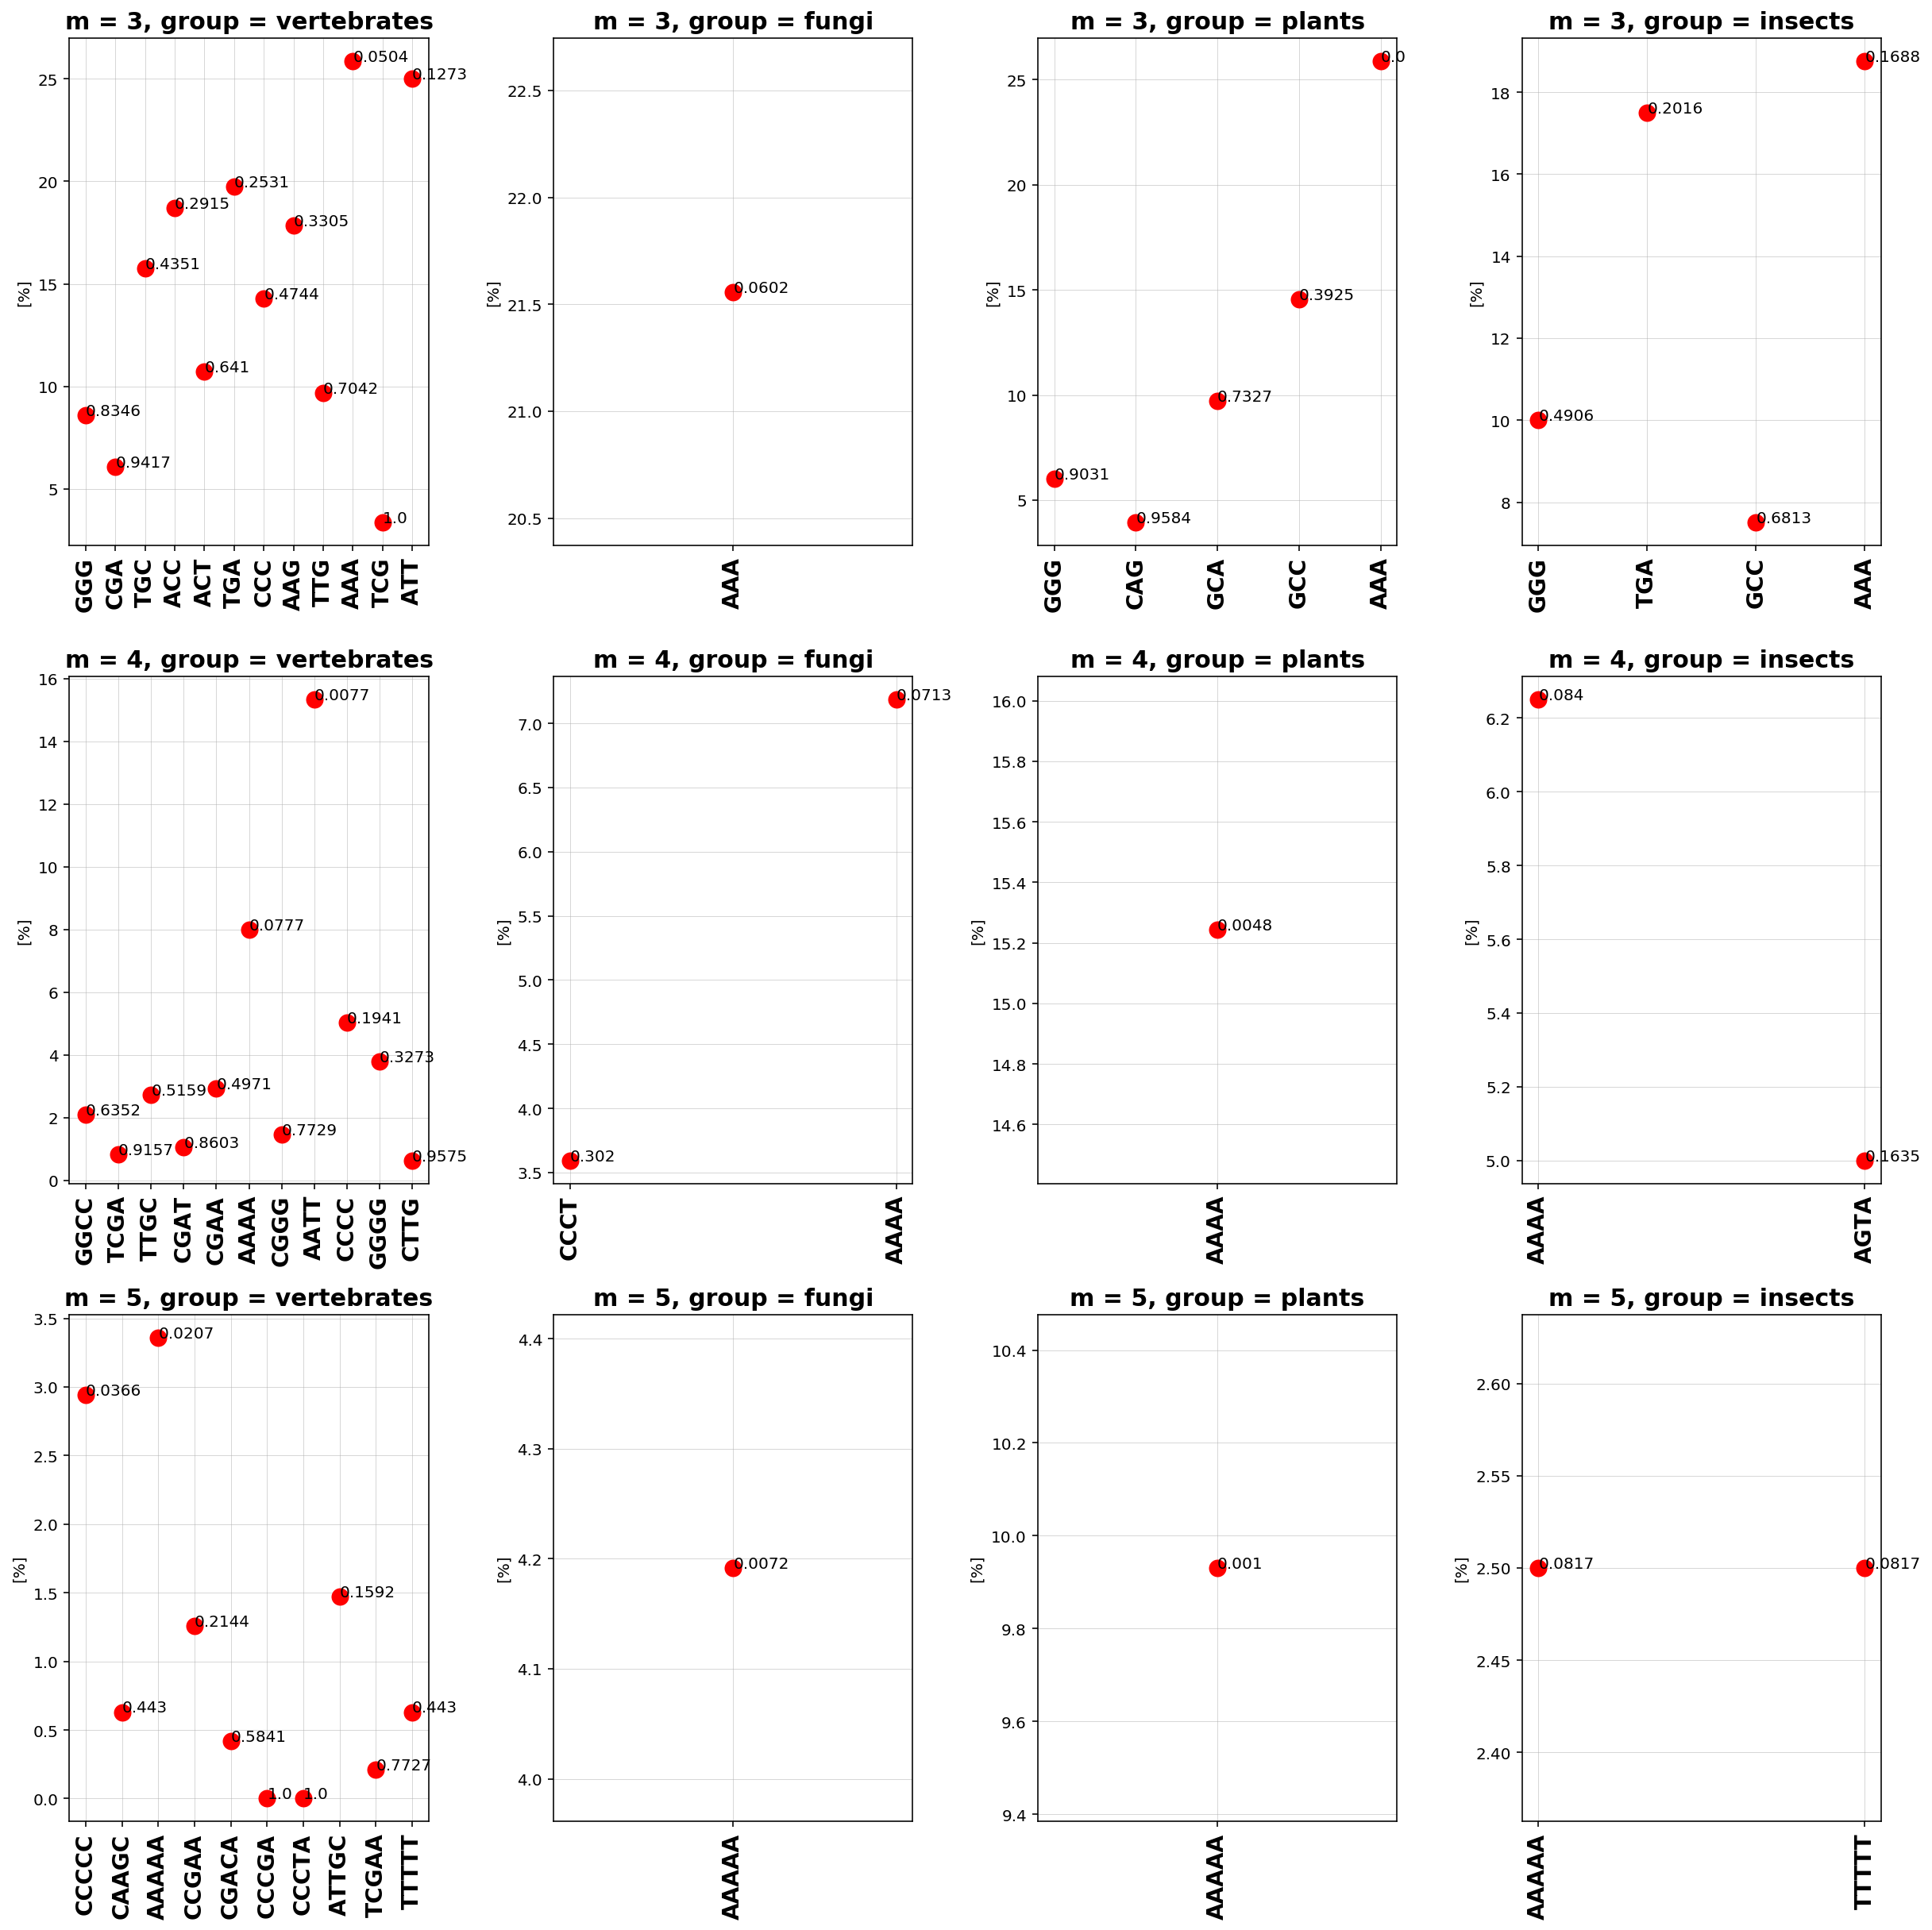

In [3]:
# key: Jaspar taxonomic group, value: corresponding vgrp_type in the top_UR_m<val> spreadsheet
jaspar_vgrp_dict = { 
    'vertebrates' : 'host Ensembl',
    'fungi' : 'host Ensembl_Fungi',
    'plants' : 'host Ensembl_Plants',
    'insects' : 'host Ensembl_Metazoa'
                   }
mlens = [3,4,5] # supported are 3, 4 and 5
num_rands = 10000
# used for calculating p-values based on URs of random viruses
base_rnd_path = '/Users/yoramzarai/work/school/Simulation/Viruses/Data_stats/UR_RandVirus_rep_'
dtype_Randvir_rnd = {'repeated_URs':str} # columns type of the URs of random viruses
fig_file = 'URs_Jasper.png'  # set to '' to disable the saving of the figure
# ==================================================================================================

%config InlineBackend.figure_format = 'retina' # Jupyter double resolution plot output for Retina display
fig = plt.figure(3,figsize=(17,17)) 
mmlens = ['m'+str(m) for m in mlens]
index = 1
for j, mlen in enumerate(mlens):
    # file containing the actual (WT) viruses URs
    UR_xlsx_file = '/Users/yoramzarai/work/school/Simulation/Viruses/Data_stats/top_UR_m'+str(mlen)+'.xlsx'
    
    '''Loading UR sequences of random viruses (of all types) for calculating p-value.'''
    if base_rnd_path: 
        xlsx_rnd_file = base_rnd_path+mmlens[j]+'_all'+'.xlsx'
        df_Rvrnd = pd.read_excel(xlsx_rnd_file, header=0, dtype=dtype_Randvir_rnd)
        cur_Rvurs = df_Rvrnd.iloc[:, 0].values # list of URs in random with multiplicity (could also use df_Rvrnd.values and then take element[0])
    
    for htax in (k for k in jaspar_vgrp_dict.keys()):  # looping over host domains
        j_dname = '/Users/yoramzarai/work/school/Simulation/Viruses/Binding_sites/TFBS/Jaspar/JASPAR2018_CORE_'\
        +htax+'_non-redundant_pfms_jaspar/'
        num_recog, UR_set, TF_info, _, _ = process_jaspar_UR(j_dname, UR_xlsx_file, jaspar_vgrp_dict[htax])

        # num_recog is in percentage
        factor = len(TF_info.keys())/100.0
        #print('p-value based on random sequences !!')
        #pvl = calc_pvalue_jaspar([i*factor for i in num_recog], TF_info, mlen, num_rands)
        pvl = calc_pvalue_randin_jaspar([i*factor for i in num_recog], TF_info, cur_Rvurs, num_rands)
        #print(num_recog, pvl, sep='\n')

        plt.subplot(len(mlens), len(jaspar_vgrp_dict), index)
        plt.plot(num_recog, 'ro', markersize=10)
        plt.xticks(range(len(UR_set)), UR_set, rotation='vertical', fontsize=14, fontweight='bold')
        plt.ylabel('[%]')
        plt.title('m = {}, group = {}'.format(mlen, htax), fontsize=15, fontweight='bold')
        for i in range(len(num_recog)):
            plt.annotate(str(pvl[i]), (i, num_recog[i]), xytext=(i, num_recog[i]), fontsize=10)
        plt.grid(linestyle='-', linewidth=0.25)
        plt.tight_layout()
        index += 1

#print((TF_info))
if fig_file:
    fig.savefig(fig_file) #, transparent=True, dpi=450)
    print('Figure saved in {} (in {})'.format(fig_file, os.getcwd()))